# Churn Analysis on Reddit User Data

In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 400)
import datetime

In [3]:
data_file_location = 'C:/Users/sundu/OneDrive - The University of Chicago/Documents/Winter 2023/RC_2012_year_cohort.feather'

In [4]:
df = pd.read_feather(data_file_location, columns=None, use_threads=True)

In [5]:
df = df[df['author'] != '[deleted]'].reset_index(drop=True)

In [6]:
print(df.head())

   created_utc             author  subreddit
0   1325376000          irwinator  AskReddit
1   1325376000            reed311   politics
2   1325376000         sagapo3851     gaming
3   1325376000       filthgrinder   politics
4   1325376001  BitterDivorcedDad        WTF


### 1. Top 30 subreddits

In [7]:
counts = df.groupby('subreddit')['author'].count()

top30 = counts.nlargest(30).reset_index(name='count')
print(top30)

              subreddit     count
0             AskReddit  25842429
1                 funny   9760035
2                  pics   7361727
3                gaming   5857771
4                   WTF   5228718
5              politics   4402819
6               atheism   4101406
7       leagueoflegends   3539247
8                  IAmA   3159398
9                 trees   3150949
10               videos   2914460
11        AdviceAnimals   2897671
12        todayilearned   2316051
13  fffffffuuuuuuuuuuuu   2304228
14            worldnews   1770750
15                  nfl   1722620
16               movies   1458599
17            starcraft   1436597
18                  aww   1385738
19             gonewild   1321255
20            Minecraft   1283522
21           technology   1193174
22               soccer   1117172
23               Diablo    962937
24           Guildwars2    955898
25                Music    945311
26                  nba    936146
27         mylittlepony    935451
28            

### 2. Filter the dataframe so you are only looking at data form a single sub-reddit.

In [9]:
def filter_subreddit(df, sub):
    filtered = df.loc[df['subreddit'] == sub].reset_index(drop=True)
    filtered = filtered.drop('subreddit', axis = 1)
    filtered['created_date'] = filtered['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    #filtered['created_date'] = filtered['created_date'].dt.days
    filtered = filtered.drop('created_utc', axis=1)
    return filtered
#Testing it out on a smaller subreddit for now
test = counts[(counts >= 999) & (counts <= 1000)].reset_index(name='count')
print(test)

               subreddit  count
0            TOUHOUMUSIC    999
1                    raw    999
2           TheMentalist   1000
3              supermoto    999
4  communityminecraftmap   1000


In [10]:
filtered = filter_subreddit(df, "communityminecraftmap")
print(filtered)

           author        created_date
0          MrBurd 2012-08-12 08:45:26
1         zetobyx 2012-08-12 09:05:00
2       jmdingess 2012-08-12 09:12:02
3    knowyourknot 2012-08-12 09:18:16
4         slithek 2012-08-12 09:24:18
..            ...                 ...
995  Blackwind123 2012-10-16 01:15:19
996      Mastadge 2012-10-27 21:01:22
997     jmdingess 2012-10-27 23:06:25
998       Swamp85 2012-10-28 00:44:57
999    filmguy100 2012-11-24 13:01:02

[1000 rows x 2 columns]


### 3. Find the date of first interaction (for that sub-reddit)

In [11]:
def find_first_inter(data, author_name):
    user_data = data[data['author'] == author_name] 
    sorted_data = user_data.sort_values(by = 'created_date')
    first_comment = sorted_data.iloc[[0]]
    return first_comment

In [12]:
first_comments = pd.DataFrame(columns=['author', 'first_comment_date'])

# loop through the unique author names in the original data frame
for author_name in filtered['author'].unique():
    # call the find_first_inter function for the current author
    first_comment = find_first_inter(filtered, author_name)
    # extract the author name and first comment date from the resulting data frame
    author = first_comment['author'].values[0]
    first_comment_date = first_comment['created_date'].values[0]
    # add the author name and first comment date to the new data frame
    first_comments = first_comments.append({'author': author, 'first_comment_date': first_comment_date}, ignore_index=True)

# print the resulting data frame
print(first_comments.head(50))

             author   first_comment_date
0            MrBurd  2012-08-12 08:45:26
1           zetobyx  2012-08-12 09:05:00
2         jmdingess  2012-08-12 09:12:02
3      knowyourknot  2012-08-12 09:18:16
4           slithek  2012-08-12 09:24:18
5   The_Skinny_Sumo  2012-08-12 09:24:45
6       Katantunoro  2012-08-12 09:58:06
7      BinaryBlowup  2012-08-12 10:05:03
8         Sphinx998  2012-08-12 10:27:46
9       s_for_scott  2012-08-12 10:32:02
10         Mastadge  2012-08-12 10:36:26
11         Jderp678  2012-08-12 10:38:48
12     danielkuzmin  2012-08-12 10:41:57
13      frostburner  2012-08-12 10:44:20
14        Tipnipdip  2012-08-12 11:05:53
15         bigbearh  2012-08-12 11:11:34
16        samzchase  2012-08-12 11:18:01
17    burning_koala  2012-08-12 11:18:16
18             idmb  2012-08-12 11:31:33
19          sargrvb  2012-08-12 11:35:45
20       FFIXMaster  2012-08-12 11:38:46
21   PancakeFashion  2012-08-12 11:40:05
22         JKatXGME  2012-08-12 11:44:14
23           Rob

### 4. Combine the initial dataframe with the dataframe containing comment timestamps

In [13]:
merged = pd.merge(first_comments, filtered, on = 'author', how = 'left')
merged['created_date'] = merged['created_date'].dt.date
merged['first_comment_date'] = pd.to_datetime(merged['first_comment_date'])
merged['first_comment_date'] = merged['first_comment_date'].dt.date
merged['day_num'] = (merged['created_date'] - merged.groupby('author')['first_comment_date'].transform('min')).dt.days

#We don't care about multiple comments. We are only care if they commented in a sub-reddit _at least_ once on that day.
merged_unique = merged.drop_duplicates(subset=['author', 'day_num'], keep='first')
print(merged_unique.head(100))

              author first_comment_date created_date  day_num
0             MrBurd         2012-08-12   2012-08-12        0
1            zetobyx         2012-08-12   2012-08-12        0
2          jmdingess         2012-08-12   2012-08-12        0
3          jmdingess         2012-08-12   2012-10-27       76
4       knowyourknot         2012-08-12   2012-08-12        0
14           slithek         2012-08-12   2012-08-12        0
15   The_Skinny_Sumo         2012-08-12   2012-08-12        0
44   The_Skinny_Sumo         2012-08-12   2012-08-13        1
73   The_Skinny_Sumo         2012-08-12   2012-08-14        2
81       Katantunoro         2012-08-12   2012-08-12        0
82      BinaryBlowup         2012-08-12   2012-08-12        0
83         Sphinx998         2012-08-12   2012-08-12        0
84       s_for_scott         2012-08-12   2012-08-12        0
91       s_for_scott         2012-08-12   2012-08-13        1
92          Mastadge         2012-08-12   2012-08-12        0
101     

### 5. Pivot the dataframe so the names of authors are on one axis and the days on which they commented are on the second axis


In [14]:
pivot_table = merged_unique.pivot_table(index='author', columns='day_num', aggfunc='size', fill_value=0)
pivot_table

day_num,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,33,34,35,37,76,103
author,,,,,,,,,,,,,,,,,,,,,
Airilsai,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AlexanderTheGreater,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Apokalyps,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arceus919,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Balinares,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bentspoon17,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BinaryBlowup,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackwind123,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BrossWallace,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Sum the number of commenters for each day

In [15]:
sum_commenters = pivot_table.sum(axis=0)
sum_commenters

day_num
0      128
1       48
2       26
3       12
4        8
5        6
6       14
7       14
8        8
9        4
10       4
11       5
12       5
13       6
14       3
15       6
17       4
18       5
19       1
20       1
21       5
22       3
23       2
24       4
25       4
26       1
27       2
28       3
29       1
30       1
31       2
33       3
34       2
35       1
37       1
76       2
103      1
dtype: int64

### 7. Calculate the % of authors who returned after their first comment

In [16]:
percentage_commenters = (sum_commenters/len(pivot_table.index))*100
print(percentage_commenters)

day_num
0      100.00000
1       37.50000
2       20.31250
3        9.37500
4        6.25000
5        4.68750
6       10.93750
7       10.93750
8        6.25000
9        3.12500
10       3.12500
11       3.90625
12       3.90625
13       4.68750
14       2.34375
15       4.68750
17       3.12500
18       3.90625
19       0.78125
20       0.78125
21       3.90625
22       2.34375
23       1.56250
24       3.12500
25       3.12500
26       0.78125
27       1.56250
28       2.34375
29       0.78125
30       0.78125
31       1.56250
33       2.34375
34       1.56250
35       0.78125
37       0.78125
76       1.56250
103      0.78125
dtype: float64


### 8. Display this series on a chart

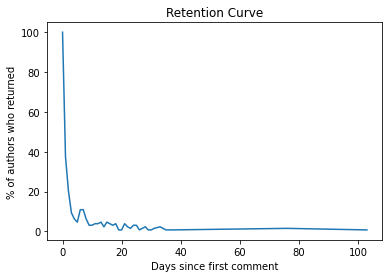

In [17]:
import matplotlib.pyplot as plt

percentage_commenters.plot()
plt.xlabel('Days since first comment')
plt.ylabel('% of authors who returned')
plt.title('Retention Curve')
plt.show()

## Now that we've tested all the above steps on a smaller subreddit, let's put everything together for the Top 30 subreddits

In [18]:
top30_subreddits = counts.nlargest(30).index.tolist()
df1 = df[df['subreddit'].isin(top30_subreddits)].reset_index(drop=True)

In [19]:
print(df1)

           created_utc             author   subreddit
0           1325376000          irwinator   AskReddit
1           1325376000            reed311    politics
2           1325376000         sagapo3851      gaming
3           1325376000       filthgrinder    politics
4           1325376001  BitterDivorcedDad         WTF
...                ...                ...         ...
102022051   1354319999           jcde7ago      Diablo
102022052   1354319999          Bandit451      gaming
102022053   1354319999          pearson32   AskReddit
102022054   1354319999           claripal       funny
102022055   1354319999     PrimeIntellect  technology

[102022056 rows x 3 columns]


In [20]:
def custom_function(f):
    first_comments = pd.DataFrame(columns=['author', 'first_comment_date'])

    # loop through the unique author names in the original data frame
    for author_name in f['author'].unique():
        # call the find_first_inter function for the current author
        first_comment = find_first_inter(f, author_name)
        # extract the author name and first comment date from the resulting data frame
        author = first_comment['author'].values[0]
        first_comment_date = first_comment['created_date'].values[0]
        # add the author name and first comment date to the new data frame
        first_comments = first_comments.append({'author': author, 'first_comment_date': first_comment_date}, ignore_index=True)
    merged = pd.merge(first_comments, f, on = 'author', how = 'left')
    merged['created_date'] = pd.to_datetime(merged['created_date'])
    #merged['created_date'] = merged['created_date'].dt.date
    merged['first_comment_date'] = pd.to_datetime(merged['first_comment_date'])
    #merged['first_comment_date'] = merged['first_comment_date'].dt.date
    merged['day_num'] = (merged['created_date'] - merged.groupby('author')['first_comment_date'].transform('min')).dt.days

    #We don't care about multiple comments. We are only care if they commented in a sub-reddit _at least_ once on that day.
    merged_unique = merged.drop_duplicates(subset=['author', 'day_num'], keep='first')
    pivot_table = merged_unique.pivot_table(index='author', columns='day_num', aggfunc='size', fill_value=0)
    sum_commenters = pivot_table.sum(axis=0)
    percentage_commenters = (sum_commenters/len(pivot_table.index))*100
    return percentage_commenters

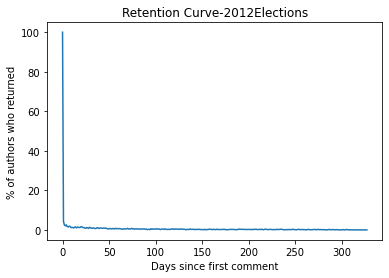

In [22]:
#Testing custom function on the smaller dataset (10,000 rows) before looping through subreddits
f = filter_subreddit(df, '2012Elections')
p = custom_function(f)
p.plot()
plt.xlabel('Days since first comment')
plt.ylabel('% of authors who returned')
plt.title('Retention Curve-2012Elections')
plt.show()

### The runtime for the top 30 subreddits was taking too long (especially for the ones with millions of rows), so we have simulated the same logic below for 30 smaller datasets


In [78]:
top_subreddits = counts[(counts >= 12000) & (counts <= 12550)].index.tolist()
print(top_subreddits)
df2 = df[df['subreddit'].isin(top_subreddits)].reset_index(drop=True)
print(df2)

['FantasyPL', 'ForeverAloneDating', 'Norway', 'Rochester', 'Supplements', 'TheWire', 'androidapps', 'arma', 'dirtypenpals', 'firefox', 'fsu', 'grammar', 'hometheater', 'mashups', 'milwaukee', 'occult', 'pkmntcg', 'rangers', 'redditguild', 'scooters', 'shorthairedhotties', 'tipofmypenis', 'torrents', 'typography', 'ABraThatFits', 'Cinemagraphs', 'Muse', 'workaholics', 'SampleSize', 'LearnUselessTalents']
        created_utc           author     subreddit
0        1325376527  psychonavigator      torrents
1        1325376820    michaellonger    typography
2        1325376974          Corgana     Rochester
3        1325377118        k_rock923     Rochester
4        1325377163        k_rock923     Rochester
...             ...              ...           ...
367512   1354319848     reverend_dan       mashups
367513   1354319863      Ameliorator     milwaukee
367514   1354319893          faheble          arma
367515   1354319957       heyblake80  dirtypenpals
367516   1354319958      I-have-

In [76]:
pivots = []
for i in range(0,len(top_subreddits)):
    f = filter_subreddit(df2, top_subreddits[i])
    p = custom_function(f)
    pivots.append(p)

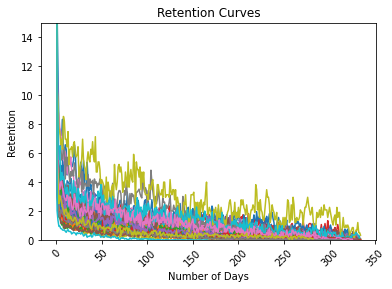

In [89]:
fig, ax = plt.subplots()

# loop through the list of pivot tables
for p in pivots:
    # plot the pivot table on the same set of axes
    p.plot(ax=ax)

# set the title and axis labels
ax.set_title('Retention Curves')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Retention')

plt.xticks(rotation = 45)
plt.ylim(0, 15)

# show the plot
plt.show()

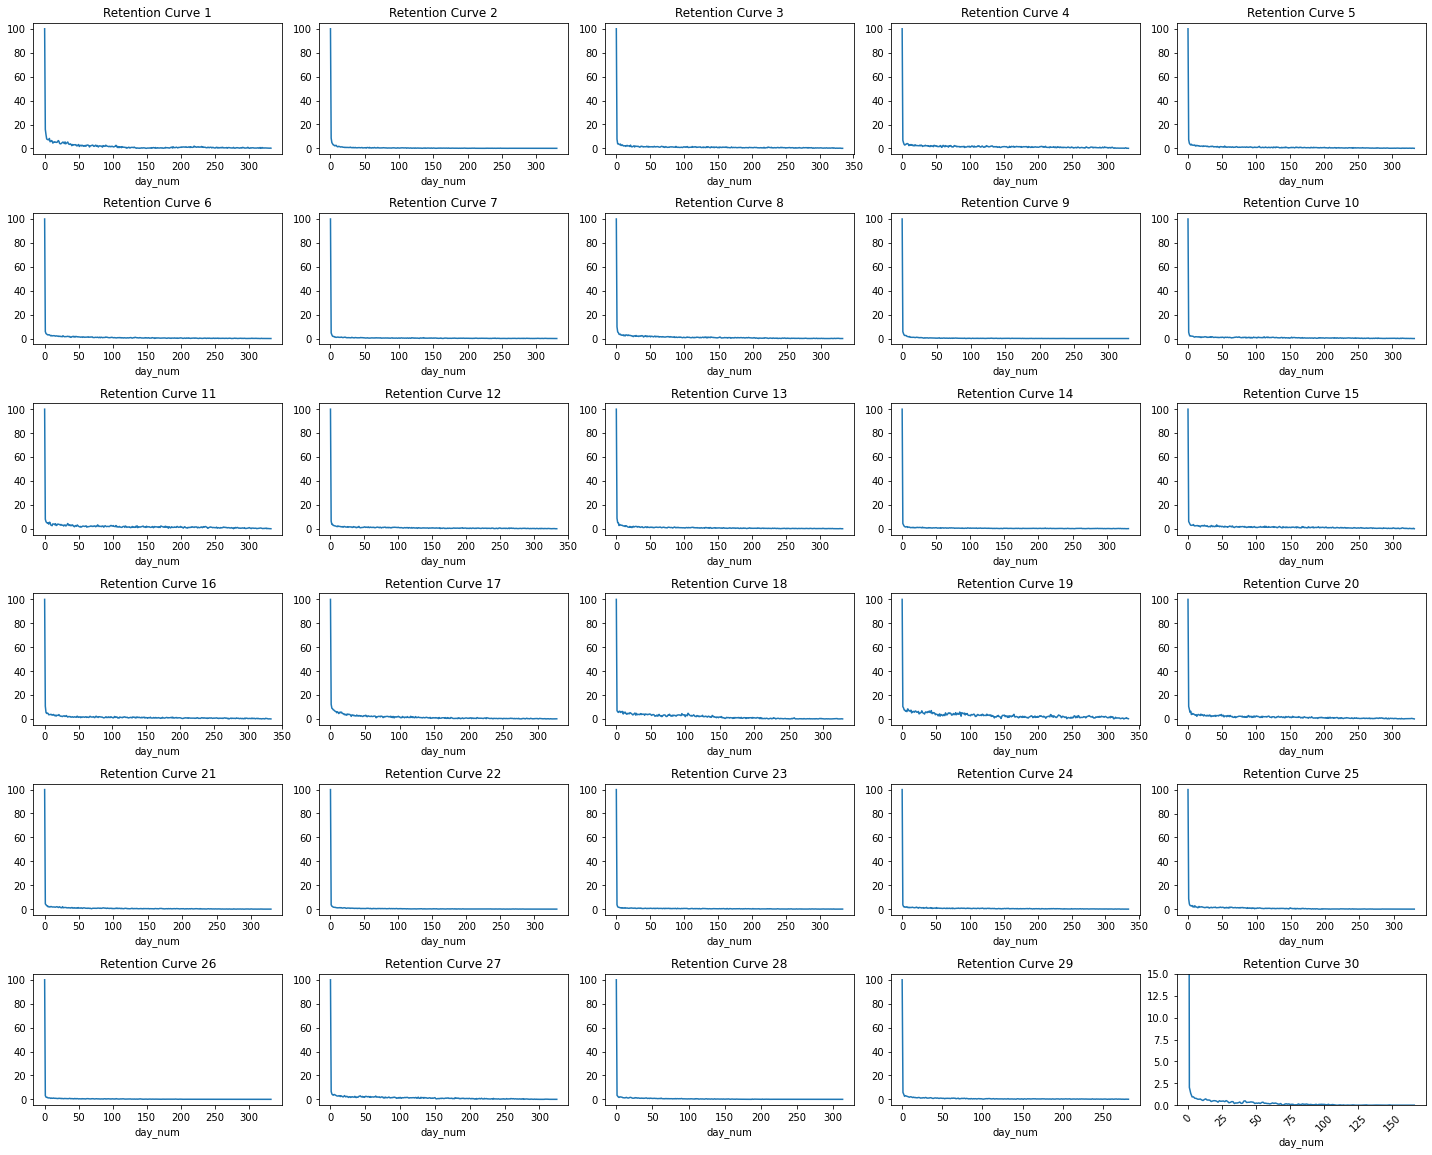

In [90]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 16))

# loop through the pivot tables and plot them in the corresponding subplot
for i, pivot in enumerate(pivots):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    pivot.plot(kind='line', ax=ax)
    ax.set_title(f"Retention Curve {i+1}")

# adjust the layout and show the plot
plt.tight_layout()
plt.xticks(rotation = 45)
plt.ylim(0, 15)
plt.show()

All the retention curves above have the typical L-shape. The retention rate drastically drops after day 0 and the curves all flatten after a few days. Looking at retention curves 1 and 19, we can see that some subreddits can keep more users engaged for slightly more number of days.

We could not show the retention plots of the largest 30 subreddits here due to computer memory issues when using pivot tables(system kept crashing). See the assignment final version document for those plots
